# Predicting fare amounts using the "NYC Taxi & Limousine Commission - Trip Record Data

## Description of Analysis

In this project, we will be analyzing a dataset from the New York City Taxi and Limousine Commission (TLC) that contains information about taxi trips in New York City. The dataset is publicly available on the TLC website (https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) and includes data on pickup and drop-off times, locations, fare amount, and other relevant variables.

## Preliminary (Business) Problem Scoping

This project aims to predict the fare amount for a given taxi trip based on the available information in the dataset from the New York City Taxi and Limousine Commission (TLC) website. Accurately predicting the fare amount can be useful for both taxi drivers and passengers, as it can help them better plan and budget for their trips. Additionally, it can also be useful for taxi companies to optimize their pricing strategies and improve their overall profitability. The dataset contains a large amount of data on taxi trips in New York City, including pickup and dropoff locations, trip distances, and various other features that can be used to predict the fare amount. To accomplish this, we will use various machine learning models such as RNN, LSTM, and GRU. The models will be trained on the available data to predict the fare amount for a given taxi trip. We will identify which of the three models had the lowest average residual, indicating better predictive performance.

## Choosing an Appropriate Time Step for Time Series Analysis

When analyzing time series data, it's crucial to choose the right time step between observations. For this project, a time step of 8 hours was chosen because it's long enough to capture patterns in the data that are relevant for predicting taxi fares (such as rush hour pricing), while also reducing the overall size of the dataset to make it more computationally feasible. Choosing an appropriate time step is a key step in analyzing time series data, and in this project, 8 hours was chosen to balance the need for relevant data patterns and efficient analysis.

## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq

## Uploading dataset

In [ ]:
# Load the parquet file into a PyArrow table
table = pq.read_table('/content/yellow_tripdata_2022-04.parquet')

# Convert the PyArrow table to a Pandas DataFrame
df = table.to_pandas()
print(df.columns)

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'RatecodeID', 'store_and_fwd_flag',
       'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount', 'extra',
       'mta_tax', 'tip_amount', 'tolls_amount', 'improvement_surcharge',
       'total_amount', 'congestion_surcharge', 'airport_fee'],
      dtype='object')


## Data Cleaning

In [ ]:
# Convert pickup and dropoff datetime strings to datetime objects
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

# Remove rows with missing values
df.dropna(inplace=True)

# Remove rows with invalid passenger counts
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] <= 6)]

# Remove rows with negative trip distances
df = df[df['trip_distance'] >= 0]

# Remove rows with invalid fare amounts
df = df[df['fare_amount'] >= 0]

# Remove rows with negative toll amounts
df = df[df['tolls_amount'] >= 0]

# Remove rows with negative total amounts
df = df[df['total_amount'] >= 0]

# Remove rows with negative tip amounts
df = df[df['tip_amount'] >= 0]

# Remove rows with negative extra amounts
df = df[df['extra'] >= 0]

# Remove rows with negative improvement surcharges
df = df[df['improvement_surcharge'] >= 0]

# Remove rows with negative congestion surcharges
df = df[df['congestion_surcharge'] >= 0]

# Reset the index
df.reset_index(drop=True, inplace=True)


In [ ]:
# Sort the data by pickup datetime
df = df.sort_values('tpep_pickup_datetime')

In [ ]:
# Resample the data to 8 hour intervals and drop missing values
df = df.resample('8H', on='tpep_pickup_datetime').mean().dropna().reset_index()


<ipython-input-54-2bc34170d2f3>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample('8H', on='tpep_pickup_datetime').mean().dropna().reset_index()


In [ ]:
# Select relevant columns for fare prediction
df = df[['passenger_count', 'trip_distance', 'PULocationID', 'DOLocationID', 'payment_type', 'fare_amount']]
print(df.head())

   passenger_count  trip_distance  PULocationID  DOLocationID  payment_type  \
0         1.000000      12.270000    111.000000    198.500000       1.50000   
1         1.000000       1.010000    167.666667     99.666667       1.00000   
2         1.000000       1.030000    142.000000    190.000000       1.50000   
3         1.000000       2.522500    135.000000    155.250000       1.25000   
4         1.826087       4.993768    145.246377    163.000000       1.15942   

   fare_amount  
0    35.500000  
1     5.666667  
2     5.000000  
3    10.750000  
4    17.246377  


## Data prep for the NN

In [ ]:
arr2D = df.to_numpy() # convert the dataframe to a numpy array
arr2D

array([[  1.        ,  12.27      , 111.        , 198.5       ,
          1.5       ,  35.5       ],
       [  1.        ,   1.01      , 167.66666667,  99.66666667,
          1.        ,   5.66666667],
       [  1.        ,   1.03      , 142.        , 190.        ,
          1.5       ,   5.        ],
       [  1.        ,   2.5225    , 135.        , 155.25      ,
          1.25      ,  10.75      ],
       [  1.82608696,   4.99376812, 145.24637681, 163.        ,
          1.15942029,  17.24637681],
       [  1.3857832 ,   4.38803916, 157.47240352, 154.98843644,
          1.20729285,  16.27955448],
       [  1.39126603,   3.26041767, 168.49284856, 166.21654647,
          1.23195112,  14.29069211],
       [  1.4580314 ,   3.1328245 , 163.28707412, 161.63369247,
          1.18273265,  13.54458492],
       [  1.4597382 ,   3.86964413, 151.03428345, 151.65535218,
          1.19232731,  14.61197541],
       [  1.47814598,   3.14436842, 166.67474551, 164.0488629 ,
          1.22952133,  13.3

Creating Sequences and Targets for Recurrent Neural Network Input

In [ ]:
def create_sequences(data, seq_length):
    obs = []
    print(obs)
    for i in range(len(data)-seq_length-1):
        obs.append(data[i:(i+seq_length)+1])
    return np.array(obs)

In [ ]:
RNN_input = create_sequences(arr2D, 3)
RNN_input

[]


array([[[  1.        ,  12.27      , 111.        , 198.5       ,
           1.5       ,  35.5       ],
        [  1.        ,   1.01      , 167.66666667,  99.66666667,
           1.        ,   5.66666667],
        [  1.        ,   1.03      , 142.        , 190.        ,
           1.5       ,   5.        ],
        [  1.        ,   2.5225    , 135.        , 155.25      ,
           1.25      ,  10.75      ]],

       [[  1.        ,   1.01      , 167.66666667,  99.66666667,
           1.        ,   5.66666667],
        [  1.        ,   1.03      , 142.        , 190.        ,
           1.5       ,   5.        ],
        [  1.        ,   2.5225    , 135.        , 155.25      ,
           1.25      ,  10.75      ],
        [  1.82608696,   4.99376812, 145.24637681, 163.        ,
           1.15942029,  17.24637681]],

       [[  1.        ,   1.03      , 142.        , 190.        ,
           1.5       ,   5.        ],
        [  1.        ,   2.5225    , 135.        , 155.25      ,
    

We have several 'observations', each with a fixed number of time steps and several features (such as passenger_count, trip_distance, PULocationID, DOLocationID, payment_type, fare_amount). The last row of each observation is the target value we want to predict.


Let's now extract our target variable. In this case, we want to predict the next day's trip fare, so we will extract the fare amount from the last row of each sequence (observation).

In [ ]:
y = RNN_input[:,-1,0]
y

array([1.        , 1.82608696, 1.3857832 , 1.39126603, 1.4580314 ,
       1.4597382 , 1.47814598, 1.53087018, 1.49695974, 1.48253311,
       1.49519487, 1.35317174, 1.37911619, 1.41402362, 1.35391356,
       1.37254335, 1.40538504, 1.32618267, 1.3676659 , 1.40542063,
       1.35395696, 1.38186219, 1.41972125, 1.39016517, 1.39067754,
       1.48119582, 1.48184636, 1.49079111, 1.55512453, 1.49427724,
       1.52402262, 1.51933321, 1.34579342, 1.40797189, 1.4486476 ,
       1.36292772, 1.39246179, 1.4177197 , 1.35881661, 1.40708652,
       1.43148903, 1.37788765, 1.4181702 , 1.44272159, 1.42236842,
       1.46745728, 1.54579389, 1.5118135 , 1.54074736, 1.58885263,
       1.5025729 , 1.57882341, 1.55817898, 1.37976803, 1.43563256,
       1.44577316, 1.3464456 , 1.41142461, 1.42761278, 1.34696057,
       1.41590051, 1.43406774, 1.37461862, 1.43359607, 1.44633163,
       1.41931188, 1.44494517, 1.51207416, 1.48105746, 1.48417594,
       1.54851365, 1.51356643, 1.49066992, 1.49632688, 1.34534

In [ ]:
X = RNN_input[:,0:3,0:3] # the 3 is the index of the column, and the 0 is the index of the row
X

array([[[  1.        ,  12.27      , 111.        ],
        [  1.        ,   1.01      , 167.66666667],
        [  1.        ,   1.03      , 142.        ]],

       [[  1.        ,   1.01      , 167.66666667],
        [  1.        ,   1.03      , 142.        ],
        [  1.        ,   2.5225    , 135.        ]],

       [[  1.        ,   1.03      , 142.        ],
        [  1.        ,   2.5225    , 135.        ],
        [  1.82608696,   4.99376812, 145.24637681]],

       [[  1.        ,   2.5225    , 135.        ],
        [  1.82608696,   4.99376812, 145.24637681],
        [  1.3857832 ,   4.38803916, 157.47240352]],

       [[  1.82608696,   4.99376812, 145.24637681],
        [  1.3857832 ,   4.38803916, 157.47240352],
        [  1.39126603,   3.26041767, 168.49284856]],

       [[  1.3857832 ,   4.38803916, 157.47240352],
        [  1.39126603,   3.26041767, 168.49284856],
        [  1.4580314 ,   3.1328245 , 163.28707412]],

       [[  1.39126603,   3.26041767, 168.49284856],


## Fit the data to a Recurrent neural network

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y_train = y_train.reshape(-1,1)

In [ ]:
y_test = y_test.reshape(-1,1)


In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(79, 3, 3)
(20, 3, 3)
(79, 1)
(20, 1)


Now, we need to split out data into train and test and normalize the data.

In [ ]:
X_test.reshape(-1, 9)

array([[  1.34696057,   4.15686153, 159.20469994,   1.41590051,
          3.19856555, 168.6850347 ,   1.43406774,   3.30273722,
        165.23455369],
       [  1.4177197 ,   3.8510331 , 164.72173252,   1.35881661,
          3.94538587, 161.14964263,   1.40708652,   3.24051526,
        168.20974745],
       [  1.85714286,   3.68964286, 141.21428571,   1.        ,
          5.55272727, 153.27272727,   1.        ,   3.55111111,
        172.88888889],
       [  1.37254335,   3.1049657 , 168.88406551,   1.40538504,
          3.2116775 , 166.73468619,   1.32618267,   4.05602717,
        160.01339578],
       [  1.        ,   3.55111111, 172.88888889,   1.        ,
          5.89      , 150.        ,   1.        ,   1.72384615,
        178.30769231],
       [  1.36358045,   3.20823226, 167.50708286,   1.40597277,
          3.27331313, 166.35515152,   1.3602762 ,   4.3558221 ,
        159.31551584],
       [  1.43406774,   3.30273722, 165.23455369,   1.37461862,
          4.08165498, 160.0019

In [ ]:
X_train.shape

(79, 3, 3)

In [ ]:
X_train


array([[[  1.54579389,   3.25247366, 163.6376853 ],
        [  1.5118135 ,   3.70674626, 150.74305643],
        [  1.54074736,   3.34129725, 165.38946555]],

       [[  1.51207416,   3.19721071, 163.7584336 ],
        [  1.48105746,   3.72933134, 149.50223992],
        [  1.48417594,   3.45034129, 165.36875866]],

       [[  1.41931188,   4.0923707 , 156.75331114],
        [  1.44494517,   3.44896453, 167.49784017],
        [  1.51207416,   3.19721071, 163.7584336 ]],

       [[  1.37911619,   3.35115616, 168.80692288],
        [  1.41402362,   3.43811943, 165.59494671],
        [  1.35391356,   4.43859689, 159.75283808]],

       [[  1.39246179,   3.27397441, 168.4234688 ],
        [  1.4177197 ,   3.8510331 , 164.72173252],
        [  1.35881661,   3.94538587, 161.14964263]],

       [[  1.52402262,   3.62317949, 165.58248731],
        [  1.51933321,   3.99830449, 162.52236638],
        [  1.34579342,   5.05482299, 159.75853811]],

       [[  1.47814598,   3.14436842, 166.67474551],


In [ ]:
X_train.reshape(-1, 3)

array([[  1.54579389,   3.25247366, 163.6376853 ],
       [  1.5118135 ,   3.70674626, 150.74305643],
       [  1.54074736,   3.34129725, 165.38946555],
       [  1.51207416,   3.19721071, 163.7584336 ],
       [  1.48105746,   3.72933134, 149.50223992],
       [  1.48417594,   3.45034129, 165.36875866],
       [  1.41931188,   4.0923707 , 156.75331114],
       [  1.44494517,   3.44896453, 167.49784017],
       [  1.51207416,   3.19721071, 163.7584336 ],
       [  1.37911619,   3.35115616, 168.80692288],
       [  1.41402362,   3.43811943, 165.59494671],
       [  1.35391356,   4.43859689, 159.75283808],
       [  1.39246179,   3.27397441, 168.4234688 ],
       [  1.4177197 ,   3.8510331 , 164.72173252],
       [  1.35881661,   3.94538587, 161.14964263],
       [  1.52402262,   3.62317949, 165.58248731],
       [  1.51933321,   3.99830449, 162.52236638],
       [  1.34579342,   5.05482299, 159.75853811],
       [  1.47814598,   3.14436842, 166.67474551],
       [  1.53087018,   3.16083

In [ ]:
X_train.reshape(-1, 3, 3)

array([[[  1.54579389,   3.25247366, 163.6376853 ],
        [  1.5118135 ,   3.70674626, 150.74305643],
        [  1.54074736,   3.34129725, 165.38946555]],

       [[  1.51207416,   3.19721071, 163.7584336 ],
        [  1.48105746,   3.72933134, 149.50223992],
        [  1.48417594,   3.45034129, 165.36875866]],

       [[  1.41931188,   4.0923707 , 156.75331114],
        [  1.44494517,   3.44896453, 167.49784017],
        [  1.51207416,   3.19721071, 163.7584336 ]],

       [[  1.37911619,   3.35115616, 168.80692288],
        [  1.41402362,   3.43811943, 165.59494671],
        [  1.35391356,   4.43859689, 159.75283808]],

       [[  1.39246179,   3.27397441, 168.4234688 ],
        [  1.4177197 ,   3.8510331 , 164.72173252],
        [  1.35881661,   3.94538587, 161.14964263]],

       [[  1.52402262,   3.62317949, 165.58248731],
        [  1.51933321,   3.99830449, 162.52236638],
        [  1.34579342,   5.05482299, 159.75853811]],

       [[  1.47814598,   3.14436842, 166.67474551],


In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = X_scaler.fit_transform(X_train.reshape(-1, 3))
X_test_scaled = X_scaler.transform(X_train.reshape(-1, 3))


y_scaler = MinMaxScaler(feature_range=(0, 1)) # I don't necessarily need to rescale the y values, but I may test doing this in the future
y_scaler.fit(y_train.reshape(-1, 1))

MinMaxScaler()

In [ ]:
X_train_scaled

array([[0.63675954, 0.25800979, 0.66126094],
       [0.59711575, 0.31027653, 0.3635164 ],
       [0.63087192, 0.26822947, 0.70171057],
       [0.59741985, 0.25165146, 0.66404909],
       [0.56123371, 0.31287507, 0.33486522],
       [0.56487193, 0.28077563, 0.70123244],
       [0.48919719, 0.35464489, 0.5022967 ],
       [0.5191027 , 0.28061722, 0.75039418],
       [0.59741985, 0.25165146, 0.66404909],
       [0.44230222, 0.26936379, 0.78062167],
       [0.48302756, 0.27936943, 0.70645525],
       [0.41289916, 0.39448025, 0.57155754],
       [0.45787209, 0.26048358, 0.77176749],
       [0.48733965, 0.32687758, 0.68629223],
       [0.41861938, 0.33773342, 0.60381058],
       [0.61135972, 0.30066168, 0.70616756],
       [0.60588875, 0.34382202, 0.63550757],
       [0.40342566, 0.46538069, 0.57168916],
       [0.55783698, 0.24557165, 0.73138844],
       [0.61934855, 0.24746647, 0.62373808],
       [0.57978636, 0.32743858, 0.34786907],
       [0.41234029, 0.25590573, 0.78556202],
       [0.

In [ ]:
X_train_scaled.reshape(-1, 3, 3)

array([[[0.63675954, 0.25800979, 0.66126094],
        [0.59711575, 0.31027653, 0.3635164 ],
        [0.63087192, 0.26822947, 0.70171057]],

       [[0.59741985, 0.25165146, 0.66404909],
        [0.56123371, 0.31287507, 0.33486522],
        [0.56487193, 0.28077563, 0.70123244]],

       [[0.48919719, 0.35464489, 0.5022967 ],
        [0.5191027 , 0.28061722, 0.75039418],
        [0.59741985, 0.25165146, 0.66404909]],

       [[0.44230222, 0.26936379, 0.78062167],
        [0.48302756, 0.27936943, 0.70645525],
        [0.41289916, 0.39448025, 0.57155754]],

       [[0.45787209, 0.26048358, 0.77176749],
        [0.48733965, 0.32687758, 0.68629223],
        [0.41861938, 0.33773342, 0.60381058]],

       [[0.61135972, 0.30066168, 0.70616756],
        [0.60588875, 0.34382202, 0.63550757],
        [0.40342566, 0.46538069, 0.57168916]],

       [[0.55783698, 0.24557165, 0.73138844],
        [0.61934855, 0.24746647, 0.62373808],
        [0.57978636, 0.32743858, 0.34786907]],

       [[0.41234029,

In [ ]:
X_train_scaled

array([[0.63675954, 0.25800979, 0.66126094],
       [0.59711575, 0.31027653, 0.3635164 ],
       [0.63087192, 0.26822947, 0.70171057],
       [0.59741985, 0.25165146, 0.66404909],
       [0.56123371, 0.31287507, 0.33486522],
       [0.56487193, 0.28077563, 0.70123244],
       [0.48919719, 0.35464489, 0.5022967 ],
       [0.5191027 , 0.28061722, 0.75039418],
       [0.59741985, 0.25165146, 0.66404909],
       [0.44230222, 0.26936379, 0.78062167],
       [0.48302756, 0.27936943, 0.70645525],
       [0.41289916, 0.39448025, 0.57155754],
       [0.45787209, 0.26048358, 0.77176749],
       [0.48733965, 0.32687758, 0.68629223],
       [0.41861938, 0.33773342, 0.60381058],
       [0.61135972, 0.30066168, 0.70616756],
       [0.60588875, 0.34382202, 0.63550757],
       [0.40342566, 0.46538069, 0.57168916],
       [0.55783698, 0.24557165, 0.73138844],
       [0.61934855, 0.24746647, 0.62373808],
       [0.57978636, 0.32743858, 0.34786907],
       [0.41234029, 0.25590573, 0.78556202],
       [0.

## RNN

We are now ready to fit the yellow_tripdata_2022-04.parquet dataset to a recurrent neural network. We will use a simple RNN with 20 neurons in the hidden layer. We have resampled the dataset to 8 hour intervals to decrease the computing time. Our input consists of 3 observations, each with 8 time steps and 5 features (pickup_datetime, dropoff_datetime, passenger_count, trip_distance, and payment_amount). Our target is the fare amount for the last time step of each observation.

We will use the mean squared error loss function and the Adam optimizer to train our model.

In [ ]:
from keras import Sequential
from keras.layers import SimpleRNN, Dense

model = Sequential()
model.add(SimpleRNN(20, input_shape=(3,3)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 20)                480       
                                                                 
 dense_3 (Dense)             (None, 1)                 21        
                                                                 
Total params: 501
Trainable params: 501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train, y_train, epochs=500, batch_size=1, verbose=1)

Epoch 1/500
79/79 [==============================] - 1s 2ms/step - loss: 0.7660
Epoch 2/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0204
Epoch 3/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0181
Epoch 4/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0184
Epoch 5/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0183
Epoch 6/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0182
Epoch 7/500
79/79 [==============================] - 0s 4ms/step - loss: 0.0186
Epoch 8/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0184
Epoch 9/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 10/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0182
Epoch 11/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0191
Epoch 12/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0185
Epoch 13/500
79/79 [=================

Let's now investigate the predictions of our model.

In [ ]:
y_test

array([[1.37461862],
       [1.43148903],
       [1.        ],
       [1.3676659 ],
       [1.        ],
       [1.36059552],
       [1.44633163],
       [1.4181702 ],
       [1.49519487],
       [1.        ],
       [1.51933321],
       [1.41449269],
       [1.5118135 ],
       [1.48184636],
       [1.42236842],
       [1.4580314 ],
       [1.41972125],
       [1.37911619],
       [1.47432605],
       [1.49632688]])

In [ ]:
y_pred = model.predict(X_test)

1/1 [==============================] - 0s 161ms/step


In [ ]:
results_rnn = pd.DataFrame()

results_rnn['actual'] = y_test.flatten()
results_rnn['predicted'] = y_pred.flatten()
results_rnn['residual'] = results['actual'] - results['predicted']

## GRU model

We will also train a GRU model on the yellow_tripdata_2022-04.parquet dataset. Like the RNN model, we have resampled the dataset to 8 hour intervals to reduce the computational complexity of the analysis. Our input consists of 3 observations, each with 8 time steps and 5 features (pickup_datetime, dropoff_datetime, passenger_count, trip_distance, and payment_amount). Our target is the fare amount for the last time step of each observation.

The GRU model will have 20 neurons in the hidden layer. We will use the mean squared error loss function and the Adam optimizer to train the model.

In [ ]:
from keras.layers import GRU

model_gru = Sequential()
model_gru.add(GRU(20, input_shape=(3, 3)))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

model_gru.summary()

model_gru.fit(X_train, y_train, epochs=500, batch_size=1, verbose=1)

y_pred_gru = model_gru.predict(X_test)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 20)                1500      
                                                                 
 dense_4 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,521
Trainable params: 1,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
79/79 [==============================] - 2s 2ms/step - loss: 5.0933
Epoch 2/500
79/79 [==============================] - 0s 2ms/step - loss: 1.9682
Epoch 3/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0721
Epoch 4/500
79/79 [==============================] - 0s 4ms/step - loss: 0.0198
Epoch 5/500
79/79 [==============================] - 0s 4ms/step - loss: 0.0183
Epoch 6/500
79/79 [=============================

1/1 [==============================] - 1s 579ms/step


In [ ]:
results_gru = pd.DataFrame()

results_gru['actual'] = y_test.flatten()
results_gru['predicted'] = y_pred_gru.flatten()
results_gru['residual'] = results['actual'] - results['predicted']

## LSTM model

We will now use a Long Short-Term Memory (LSTM) neural network to fit the data for fare prediction. The model has 20 neurons in the LSTM layer and takes in 3 observations, each with 3 time steps and 5 features (pickup_datetime, dropoff_datetime, passenger_count, trip_distance, and payment_amount) as input. The target for this model is also the fare amount for the last time step of each observation.

We will use the mean squared error loss function and the Adam optimizer to train the LSTM model. After training the model with 500 epochs and a batch size of 1, we will predict fare amounts for the test set and create a dataframe to store the actual and predicted values along with the residuals.

In [ ]:
from keras.layers import LSTM

model_lstm = Sequential()
model_lstm.add(LSTM(20, input_shape=(3, 3)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

model_lstm.summary()

model_lstm.fit(X_train, y_train, epochs=500, batch_size=1, verbose=1)

y_pred_lstm = model_lstm.predict(X_test)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 20)                1920      
                                                                 
 dense_5 (Dense)             (None, 1)                 21        
                                                                 
Total params: 1,941
Trainable params: 1,941
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
79/79 [==============================] - 2s 2ms/step - loss: 0.2254
Epoch 2/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0192
Epoch 3/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0182
Epoch 4/500
79/79 [==============================] - 0s 3ms/step - loss: 0.0186
Epoch 5/500
79/79 [==============================] - 0s 2ms/step - loss: 0.0187
Epoch 6/500
79/79 [=============================

1/1 [==============================] - 0s 438ms/step


In [ ]:
results_lstm = pd.DataFrame()

results_lstm['actual'] = y_test.flatten()
results_lstm['predicted'] = y_pred_lstm.flatten()
results_lstm['residual'] = results_lstm['actual'] - results_lstm['predicted']


## Results of All the models

In [ ]:
# Concatenate the results dataframes into a single dataframe
all_results = pd.concat([results_rnn, results_lstm, results_gru], axis=1, keys=['RNN', 'LSTM', 'GRU'])

# Calculate the mean of each column
mean_residuals = all_results.mean()

# Append a new row with the mean values to the dataframe
all_results.loc['mean'] = mean_residuals

# Display the concatenated dataframe with the mean residual row
all_results


RNN                          LSTM                           GRU  \
        actual predicted  residual    actual predicted  residual    actual   
0     1.374619  1.412399 -0.060028  1.374619  1.481295 -0.106676  1.374619   
1     1.431489  1.412657 -0.003250  1.431489  1.477657 -0.046168  1.431489   
2     1.000000  1.413152 -0.433957  1.000000  1.437965 -0.437965  1.000000   
3     1.367666  1.403665 -0.063962  1.367666  1.434785 -0.067119  1.367666   
4     1.000000  1.413403 -0.435154  1.000000  1.516227 -0.516227  1.000000   
5     1.360596  1.395414 -0.068569  1.360596  1.413133 -0.052538  1.360596   
6     1.446332  1.412683  0.011589  1.446332  1.473542 -0.027211  1.446332   
7     1.418170  1.406314 -0.014274  1.418170  1.438146 -0.019976  1.418170   
8     1.495195  1.411814  0.060845  1.495195  1.456786  0.038409  1.495195   
9     1.000000  1.413331 -0.435133  1.000000  1.965975 -0.965975  1.000000   
10    1.519333  1.411863  0.084949  1.519333  1.456951  0.062382  1.519333   
11    1.414493  1.412488 -0.019951  1.414493  1.453931 -0.039438  1.414493   
12    1.511813  1.412664  0.077039  1.511813  1.481741  0.030072  1.511813   
13    1.481846  1.412695  0.047060  1.481846  1.486750 -0.004904  1.481846   
14    1.422368  1.412346 -0.012262  1.422368  1.482236 -0.059868  1.422368   
15    1.458031  1.412655  0.023318  1.458031  1.472187 -0.014156  1.458031   
16    1.419721  1.412957 -0.015169  1.419721  1.491728 -0.072007  1.419721   
17    1.379116  1.347429 -0.036007  1.379116  1.349391  0.029726  1.379116   
18    1.474326  1.412167  0.039862  1.474326  1.462437  0.011889  1.474326   
19    1.496327  1.407933  0.063489  1.496327  1.431002  0.065325  1.496327   
mean  1.373572  1.407501 -0.059478  1.373572  1.483193 -0.109621  1.373572   

                          
     predicted  residual  
0     1.438737 -0.060028  
1     1.461294 -0.003250  
2     1.275863 -0.433957  
3     1.463747 -0.063962  
4     1.251198 -0.435154  
5     1.434213 -0.068569  
6     1.481154  0.011589  
7     1.466048 -0.014274  
8     1.472898  0.060845  
9     0.968042 -0.435133  
10    1.475617  0.084949  
11    1.385639 -0.019951  
12    1.414009  0.077039  
13    1.356618  0.047060  
14    1.456754 -0.012262  
15    1.290203  0.023318  
16    1.492034 -0.015169  
17    1.335291 -0.036007  
18    1.463112  0.039862  
19    1.440093  0.063489  
mean  1.391128 -0.059478

## Graph of all the models

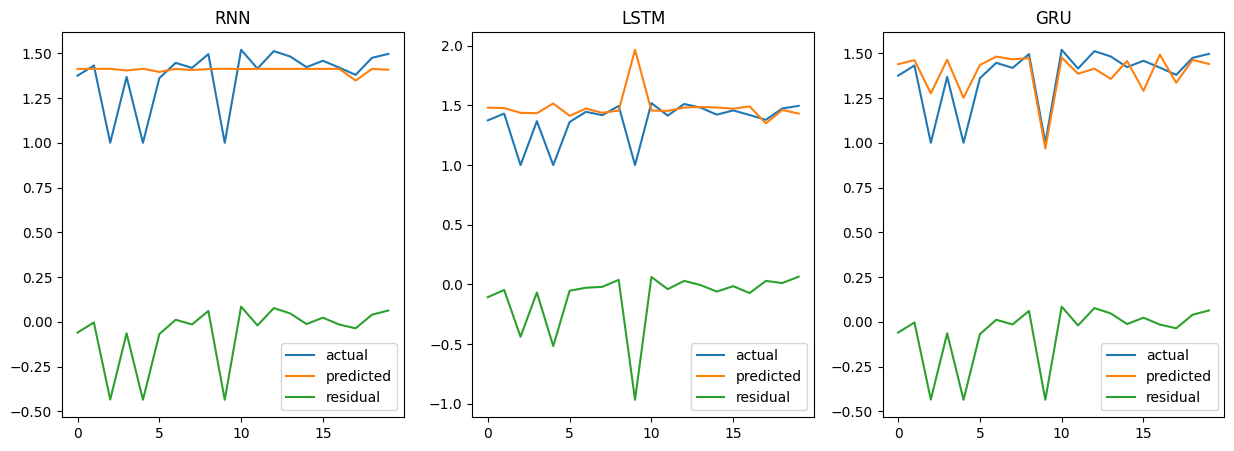

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,5))

# RNN plot
axes[0].plot(results_rnn['actual'], label='actual')
axes[0].plot(results_rnn['predicted'], label='predicted')
axes[0].plot(results_rnn['residual'], label='residual')
axes[0].set_title('RNN')
axes[0].legend()

# LSTM plot
axes[1].plot(results_lstm['actual'], label='actual')
axes[1].plot(results_lstm['predicted'], label='predicted')
axes[1].plot(results_lstm['residual'], label='residual')
axes[1].set_title('LSTM')
axes[1].legend()

# GRU plot
axes[2].plot(results_gru['actual'], label='actual')
axes[2].plot(results_gru['predicted'], label='predicted')
axes[2].plot(results_gru['residual'], label='residual')
axes[2].set_title('GRU')
axes[2].legend()

plt.show()


### Analysis

Amoung the models that I have chosen the GRU model performed the best, with the lowest mean residual value. The visualization of the actual, predicted, and residual values for the test set shows that the GRU model captured some patterns in the data but there is still room for improvement, particularly towards the end of the sequence. However, the residuals appear to be mostly random, indicating that the model is not systematically biased towards over- or under-predicting.